In [4]:
import pandas as pd
import numpy as np
from ast import literal_eval
from collections import defaultdict
from itertools import chain
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt

sponge_df = pd.read_csv('sponge_df_script.csv',index_col= 0, converters={'Script': literal_eval})

One note: the first time in the series the character is introduced, they are introduced in a full name and a shortened one for the rest. Since this is applied to every character in the series it's fine. 

In [5]:
# create character dicts
list_of_character_dicts = []
for title in list(sponge_df.Title):
    character_dict = defaultdict(int)
    episode_name = title
    script = list(sponge_df.query("Title == @episode_name")['Script'])[0]
    for i in range(len(script)):
        character_dict[script[i].split(':')[0]] += 1
    character_dict = sorted(
        character_dict.items(),
        key=lambda x: x[1],
        reverse=True)
    list_of_character_dicts.append(dict(character_dict))

In [6]:
# normalize the character dicts
normalized_char_dicts = []
for dict in list_of_character_dicts:
    sum_ = sum(dict.values())
    normalized = { k:v/sum_ for (k,v) in zip(dict.keys(),
                            dict.values())} 
    normalized_char_dicts.append(normalized)

##### For our analysis, we will really only care about the significant characters. Thus, we will add their speaking rates to our dataframe. Let's consider a `significant` character one who speaks in at least n% of the episodes. Though we will make this parameter `speak_rate` flexible. We need to find a good cutoff, maybe a visualization should help.

In [7]:
# preassumed speak rate
speak_rate = 0.4
total_chars = []
for i in range(len(list_of_character_dicts)):
    episode_chars = list_of_character_dicts[i]
    total_chars.append(
        [k for k,v in zip(episode_chars.keys(), episode_chars.values())]
        )
appearance_counts = Counter(list(chain(*total_chars)))#.most_common()

In [8]:
# create counter object
min_threshold = round(len(sponge_df) * speak_rate)
{x: count for x, count in appearance_counts.items() if count >= min_threshold}

{'SpongeBob': 389, 'Mr. Krabs': 259, 'Squidward': 294, 'Patrick': 264}

Note: appearance_counts might make a good histogram

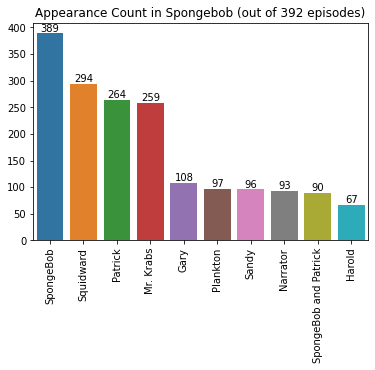

In [9]:

most_common_chars = appearance_counts.most_common()[:10]
most_common_chars
chars = [char[0] for char in most_common_chars]
vals = [char[1] for char in most_common_chars]
chars = [char[0] for char in most_common_chars]
ax = sns.barplot(x = chars, y = vals)
plt.xticks(rotation = 90)
plt.title('Appearance Count in Spongebob (out of 392 episodes)')

ax.bar_label(ax.containers[0])
plt.show()


##### From the image above, it is shown that our cutoff should be after Mr. Krabs

In [10]:
# create function to apply to dataframe 
def get_char_speak_rate(dict,char):
     if dict.get(char):
          return dict.get(char)


In [11]:
# create a copy of the dataframe, we don't wanna mess with that 
sponge_df_line_share  = sponge_df.copy()
sponge_df_line_share['normalized_dict'] = normalized_char_dicts

In [12]:
# add characters to dataframe
for character in ['SpongeBob', 'Squidward', 'Patrick', 'Mr. Krabs', 'Plankton','Gary']:
    sponge_df_line_share[character] = sponge_df_line_share.normalized_dict.apply(
        get_char_speak_rate,char = character)
sponge_df_line_share.drop(['normalized_dict'], axis = 1, inplace = True)

In [13]:
# preview df
sponge_df_line_share.sort_values(by = 'Rating', ascending = False).head(5)

,Episode #,Title,Rating,Script,SpongeBob,Squidward,Patrick,Mr. Krabs,Plankton,Gary
64,64,The Secret Box,9.7,"[Patrick: Oh, boy, am I!, SpongeBob: Here's yo...",0.482143,NaN,0.482143,NaN,NaN,0.017857
98,98,Wet Painters,9.5,"[ \t \t \t\t \t\t\t \t\t \t\t \t\t \t , Narra...",0.370370,0.009259,0.296296,0.194444,NaN,NaN
86,86,Nasty Patty,9.5,"[Narrator: Oh, a dark and stormy night. It's ...",0.327586,NaN,NaN,0.405172,NaN,NaN
87,87,Idiot Box,9.5,"[SpongeBob: See anything yet, Patrick?, Patric...",0.357143,0.241071,0.276786,NaN,NaN,NaN
102,102,Mermaidman and Barnacleboy V,9.5,[Narrator: The New Adventures of Mermaid Man a...,0.130081,0.073171,0.048780,0.016260,NaN,NaN


In [14]:
sponge_df_line_share['Gary'].min()

0.0051635111876075735

In [15]:
# fill NaNs because we can't do arithmetic with them
sponge_df_line_share = sponge_df_line_share.fillna(0)


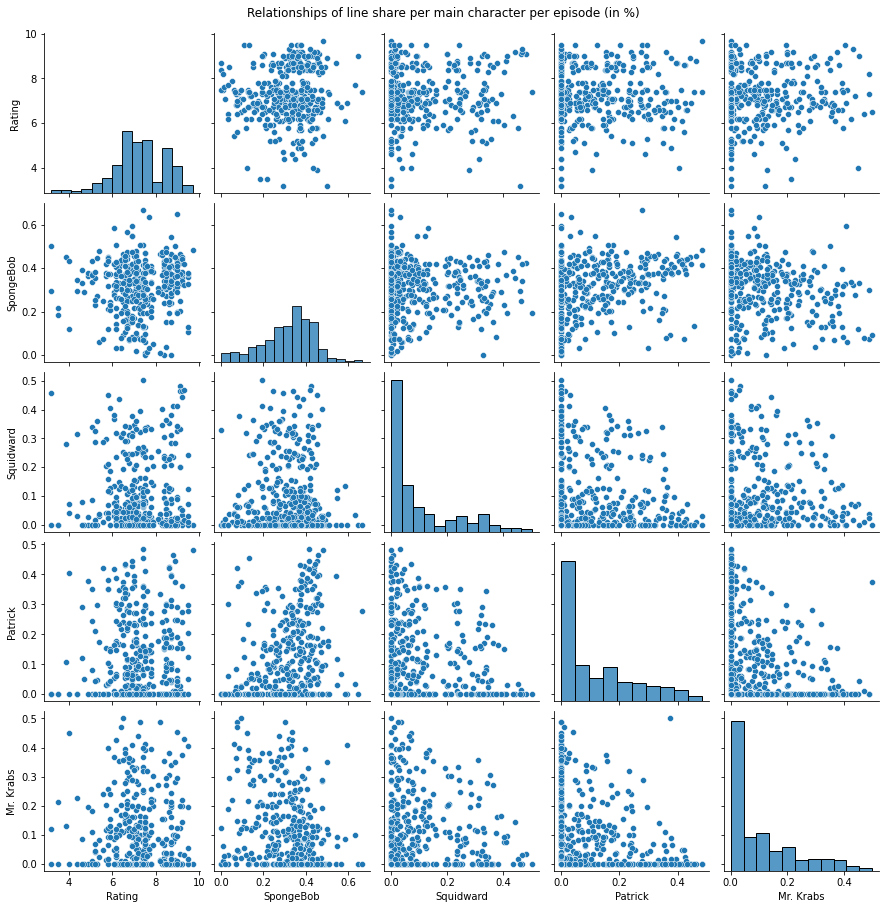

In [16]:
# looks for relationships in variables
line_share_plot = sns.pairplot(sponge_df_line_share[['Rating', 'SpongeBob', 'Squidward', 
                                  'Patrick', 'Mr. Krabs']])

line_share_plot.fig.suptitle('Relationships of line share per main character per episode (in %)', y = 1.01)

plt.show()

In [17]:
# look for correlations between characters, doesn't seem to be anything there
sponge_df_line_share[['Rating', 'SpongeBob', 'Squidward', 
                                  'Patrick', 'Mr. Krabs']].corr()

,Rating,SpongeBob,Squidward,Patrick,Mr. Krabs
Rating,1.000000,0.064122,0.015291,0.011603,-0.021362
SpongeBob,0.064122,1.000000,-0.028451,0.258829,-0.256379
Squidward,0.015291,-0.028451,1.000000,-0.169161,-0.052218
Patrick,0.011603,0.258829,-0.169161,1.000000,-0.378344
Mr. Krabs,-0.021362,-0.256379,-0.052218,-0.378344,1.000000


Now, let's classify the types of episodes and see if they have any effect on the rating. The two recurring episode settings are Krusty Krab episodes and Home episodes. Krabs and Plankton rarely have a significant role outside the Krusty Krab themed episodes, so let;s look for episodes that have a >=20% contribution between the two of them. 

Home episodes will be looked at next, and Patrick and Gary having a 20% contribution will be searched for here. The reason we are doing it in this order is because Patrick has a lot of contributions at the Krusty Krab, whereas Krabs and Plankton have virtually no contribution at the home episodes 

In [18]:
conditions = [
    sponge_df_line_share['Mr. Krabs'] + sponge_df_line_share.Plankton >= 0.2,
    sponge_df_line_share.Patrick + sponge_df_line_share.Gary >= 0.2,
    (sponge_df_line_share['Mr. Krabs'] + sponge_df_line_share.Plankton <= 0.2) &
    (sponge_df_line_share.Patrick + sponge_df_line_share.Gary <= 0.2)
]

results = ['Krusty Krab', 'Home', 'Other']
sponge_df_line_share['Type'] = np.select(conditions, results)

In [26]:
sponge_df_line_share[['Type']].value_counts()

Type       
Other          158
Krusty Krab    124
Home           110
dtype: int64

In [20]:
import scipy.stats as stats
stats.ttest_ind(sponge_df_line_share['Rating'][sponge_df_line_share['Type'] == 'Krusty Krab'],
                sponge_df_line_share['Rating'][sponge_df_line_share['Type'] == 'Other'])

Ttest_indResult(statistic=-0.6251091760311828, pvalue=0.5324085087901957)

In [21]:
stats.ttest_ind(sponge_df_line_share['Rating'][sponge_df_line_share['Type'] == 'Home'],
                sponge_df_line_share['Rating'][sponge_df_line_share['Type'] == 'Other'])

Ttest_indResult(statistic=-0.8736381551373774, pvalue=0.3831033595642128)

In [22]:
stats.ttest_ind(sponge_df_line_share['Rating'][sponge_df_line_share['Type'] == 'Krusty Krab'],
                sponge_df_line_share['Rating'][sponge_df_line_share['Type'] == 'Home'])

Ttest_indResult(statistic=0.31940228841086354, pvalue=0.749708891932746)

<AxesSubplot:xlabel='Episode #', ylabel='Rating'>

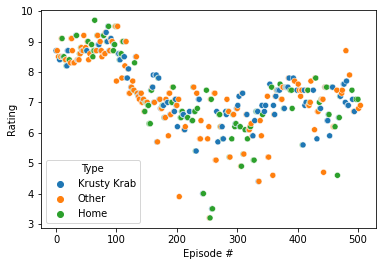

In [23]:
sns.scatterplot(
    data = sponge_df_line_share,
    x = 'Episode #',
    y = 'Rating',
    hue = 'Type'
)

In [24]:
sponge_df_line_share.groupby('Type')['Rating'].describe()


,count,mean,std,min,25%,50%,75%,max
Type,,,,,,,,
Home,110.0,7.190909,1.304231,3.2,6.500,7.0,8.4,9.7
Krusty Krab,124.0,7.240323,1.060213,3.5,6.675,7.1,7.8,9.5
Other,158.0,7.325949,1.201760,3.2,6.700,7.3,8.4,9.5


Nothing really here, so let's see if certain characters' appearances have an effect on the rating.